In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
# seq values 
row_count = 500
val_count = 100
test_count =100
val_st,val_end = row_count-(val_count+test_count),row_count-test_count

data=pd.DataFrame({'seq_values':np.sin(list(range(row_count))) })
data['index'] = data.index
data.head()

,seq_values,index
0,0.000000,0
1,0.841471,1
2,0.909297,2
3,0.141120,3
4,-0.756802,4


In [25]:
train_data = data.iloc[:val_st].reset_index(drop=True)
train_data['tgt_values'] = train_data['seq_values'].shift(-1)
#shiting to start the indexing from 1 onwards to align with the hidden states since h0 is random initiation
train_data = train_data.dropna().shift(1)

val_data = data.iloc[val_st:val_end].reset_index(drop=True)
val_data['tgt_values'] = val_data['seq_values'].shift(-1)
#shiting to start the indexing from 1 onwards to align with the hidden states since h0 is random initiation
val_data = val_data.dropna().shift(1)

test_data = data.iloc[val_end:row_count].reset_index(drop=True)
test_data['tgt_values'] = test_data['seq_values'].shift(-1)
#shiting to start the indexing from 1 onwards to align with the hidden states since h0 is random initiation
test_data = test_data.dropna().shift(1)

# plt.figure(figsize=(25,3))
# sns.lineplot(data=train_data, y='seq_values', x='index',label='train')
# sns.lineplot(data=val_data, y='seq_values', x='index', label='validation')
# sns.lineplot(data=test_data, y='seq_values', x='index', label='testing')

In [356]:
input_size = 1
hidden_size = 5
output_size = 1

params= {}
params['wxh'] = np.random.randn(hidden_size, output_size)
params['whh'] = np.random.randn(hidden_size,hidden_size)
params['why'] = np.random.randn(output_size,hidden_size)
params['ch'] = np.zeros((hidden_size,1))
params['cy'] = np.zeros((output_size,1))

# wxh,whh,why, = [np.random.normal() for i in range(5)]
# cy,ch = 0,0
learning_rate = 0.01

xt_trn = train_data['seq_values'].to_numpy()
yt_true_trn = train_data['tgt_values'].to_numpy()

xt_val = val_data['seq_values'].to_numpy()
yt_true_val = val_data['tgt_values'].to_numpy()

trn_loss_arry, val_loss_arry,  = [],[]

grad_dct = {'wxh':[],'whh':[],'why':[],'cy':[],'ch':[]}

for epoch in range(0,20):

    ht_arry, yt_trn_pred_arry= [np.zeros_like(params['wxh'])],[None]
    trn_epoch_loss, val_epoch_loss =0,0
    delta_y_arry = [None]

    # forward pass
    for t_step in range(1,len(train_data)):
        # ht = np.tanh(ch + whh*ht_arry[t_step-1] + wxh*xt_trn[t_step])
        # yt_pred = cy + why*ht

        ht = np.tanh(params['ch'] + np.dot(params['whh'],ht_arry[t_step-1]) + np.dot(params['wxh'],xt_trn[t_step]) )
        yt_pred = params['cy'] + np.dot(params['why'],ht )

        ht_arry.append(ht)
        yt_trn_pred_arry.append(yt_pred)

        delta_y = yt_true_trn[t_step]-yt_pred
        delta_y_arry.append(delta_y)

        loss = delta_y**2
        trn_epoch_loss+=loss[0][0]

    ht_val_arry, yt_val_pred_arry= [np.zeros_like(params['wxh'])],[None]

    for t_step in range(1,len(val_data)):
        # ht = np.tanh(ch + whh*ht_val_arry[t_step-1] + wxh*xt_val[t_step])
        # yt_pred = cy + why*ht

        ht = np.tanh(params['ch'] + np.dot(params['whh'],ht_val_arry[t_step-1]) + np.dot(params['wxh'],xt_val[t_step]))
        yt_pred = params['cy'] + np.dot(params['why'],ht )

        ht_val_arry.append(ht)
        yt_val_pred_arry.append(yt_pred)
        
        val_loss = (yt_true_val[t_step]-yt_pred)**2
        val_epoch_loss+=val_loss[0][0]

    trn_loss_arry.append(trn_epoch_loss)
    val_loss_arry.append(val_epoch_loss)

    # if epoch%50==0:
    print(f'train_cost:{trn_epoch_loss} | validation_cost: {val_epoch_loss}' )

    # dwhy,dwxh, dwhh, dch, dcy,dhnext =0,0,0,0,0,0
    # dwhy,dwxh, dwhh = np.zeros_like(params['why']), np.zeros_like(params['wxh']), np.zeros_like(params['whh'])

    grads = {}
    grads['dwhy'], grads['dwxh'], grads['dwhh'] = np.zeros_like(params['why']), np.zeros_like(params['wxh']), np.zeros_like(params['whh'])
    grads['dhnext'] = np.zeros_like(ht_arry[-1])
    grads['dch'], grads['dcy'] = np.zeros_like(params['ch'] ), np.zeros_like(params['cy'] )


    #backprob through time
    for t_step in reversed(range(1,len(train_data))):
        dy = (-2)*delta_y_arry[t_step] # derivative of squared loss

        # dh = dy*why+dhnext
        dh = np.dot(params['why'].T,dy) + grads['dhnext'] # 10x1

        dhraw = dh*(1-ht_arry[t_step]**2) # 10x1

        # dwhh+= dhraw*ht_arry[t_step-1]
        grads['dwhh'] += np.dot(dhraw,ht_arry[t_step-1].T) # 10x10

        # dwxh+= dhraw*xt_trn[t_step]
        grads['dwxh'] += np.dot(dhraw,xt_trn[t_step].reshape(1,1)) # 10x1

        # dwhy+=dy*dh
        grads['dwhy'] += np.dot(dy,dh.T ) # 1 x10

        # dcy+=dy
        grads['dcy'] += dy # 1x1

        # dch+=dhraw
        grads['dch'] += dhraw # 10x1
        
        # dhnext = whh*dhraw
        grads['dhnext'] = np.dot(params['whh'].T, dhraw)

    for key in ['wxh','whh','why','cy','ch']:
        grads[f'd{key}'] = np.clip(grads[f'd{key}'], -4, 4)
        # grad = np.clip(grad, -10, 10)
        params[key]=(params[key]-learning_rate*grads[f'd{key}'])

    # for param, grad, key in zip(params.values(),grads.values(),['wxh','whh','why','cy','ch']):
    #     grad = np.clip(grad, -10, 10)
    #     grad_dct[key].append(param-learning_rate*grad)

    # wxh,whh,why,cy,ch = grad_dct['wxh'][-1],grad_dct['whh'][-1],grad_dct['why'][-1],grad_dct['cy'][-1],grad_dct['ch'][-1]


train_cost:1213.8519538957066 | validation_cost: 397.5878135727878
train_cost:1040.6854798448053 | validation_cost: 329.8809355417611
train_cost:796.3709010219461 | validation_cost: 257.4375112021541
train_cost:699.4552083251759 | validation_cost: 220.47716591770939
train_cost:558.2866712256396 | validation_cost: 179.88646783497217
train_cost:418.94834911789445 | validation_cost: 133.7899115796507
train_cost:264.6907066632904 | validation_cost: 85.49273780667045
train_cost:150.3347925862337 | validation_cost: 47.707014487741155
train_cost:98.63669278069474 | validation_cost: 31.69080143466892
train_cost:66.06937793923791 | validation_cost: 21.399542853610846
train_cost:56.36226386295806 | validation_cost: 18.405317181631727
train_cost:34.924429232041 | validation_cost: 11.236293981429021
train_cost:42.93422448134891 | validation_cost: 13.887188357077106
train_cost:28.581032206895703 | validation_cost: 9.120690995391396
train_cost:31.675889702274677 | validation_cost: 10.339586487092403

In [92]:
print(dhraw.shape)
print(ht_arry[t_step-1].T.shape)
print(np.dot(dhraw,ht_arry[t_step-1].T).shape)
print(dy.shape, dh.T.shape )
print(params['whh'].shape,dhraw.shape)

(10, 1)
(1, 10)
(10, 10)
(1, 1) (1, 10)
(10, 10) (10, 1)


In [41]:
# yt_true_trn
# yt_trn_pred_arry

<Axes: >

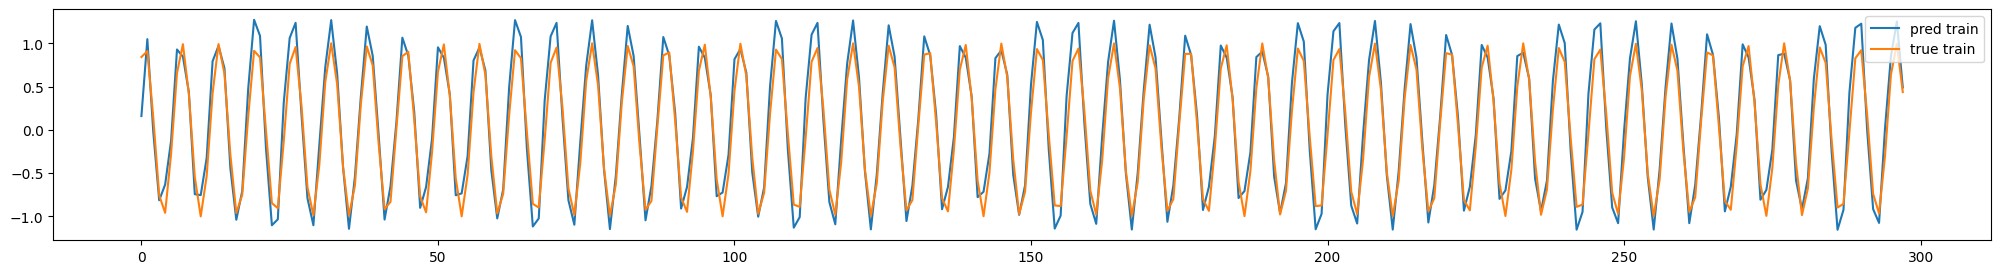

In [357]:
plt.figure(figsize=(25,3))

flat_pred = [pred[0][0] for pred in yt_trn_pred_arry[1:]]
sns.lineplot(x=range(len(flat_pred)), y=flat_pred, label='pred train')
sns.lineplot(x=range(len(yt_true_trn[1:])), y=yt_true_trn[1:], label='true train')

<Axes: >

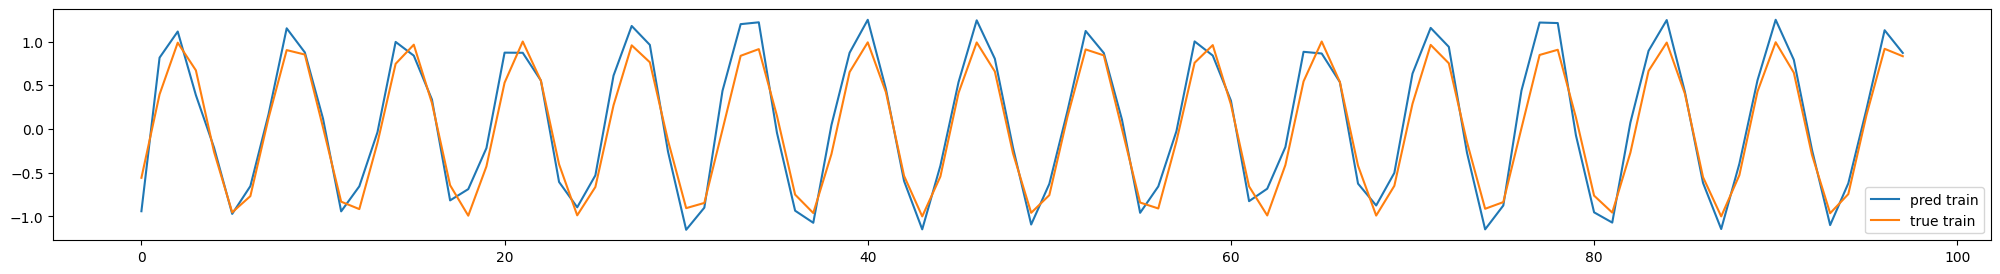

In [358]:
plt.figure(figsize=(25,3))
flat_val_pred = [pred[0][0] for pred in yt_val_pred_arry[1:]]
sns.lineplot(x=range(len(flat_val_pred)), y=flat_val_pred, label='pred train')
sns.lineplot(x=range(len(yt_true_val[1:])), y=yt_true_val[1:], label='true train')

<Axes: >

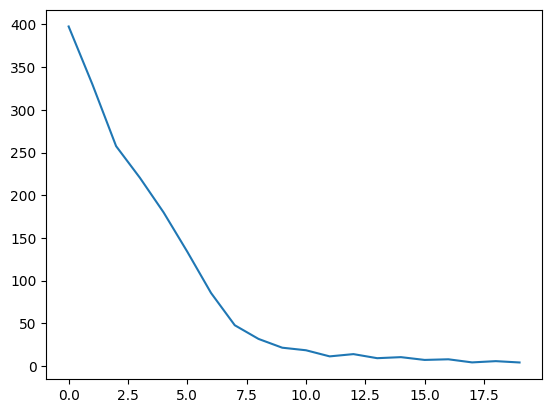

In [362]:
sns.lineplot(val_loss_arry)